<a href="https://colab.research.google.com/github/nandwanatarun/EVA-DeepLearning/blob/Session-14/S14_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Resources**

- XLA

    - [Google Notebook example](https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/compiler/xla/g3doc/tutorials/xla_compile.ipynb)

    - [Blog](https://medium.com/@xianbao.qian/use-xla-with-keras-3ca5d0309c26)
    
- Mixed Precision

- Augmentation Libs
    - [imgaug](https://github.com/aleju/imgaug)
    - [albumentations](https://github.com/albu/albumentations)
    - [Automold](https://github.com/UjjwalSaxena/Automold--Road-Augmentation-Library)
    - [Tensorflow Examples](https://www.wouterbulten.nl/blog/tech/data-augmentation-using-tensorflow-data-dataset/)

In [1]:
import numpy as np
import skimage
print(np.__version__)
print(skimage.__version__)

import time, math
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import tensorflow.contrib.eager as tfe
import gc
print(tf.__version__)

import matplotlib.pyplot as plt
% matplotlib inline
%config InlineBackend.figure_format='retina'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import imgaug.augmenters as iaa



from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,RandomScale,Rotate,HorizontalFlip,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,RandomCrop,PadIfNeeded,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,#RandomFog,
    GridDistortion,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, #ChannelDropout, 
    ChannelShuffle,RandomContrast
)

1.17.4
0.15.0


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

1.15.0


In [0]:
tf.enable_eager_execution()
# tf.random.set_random_seed(1234)

In [3]:
BATCH_SIZE = 512 #@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
LEARNING_RATE = 0.4 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS = 24 #@param {type:"integer"}
cutout_proba = 0.4
shift_proba = 0.0
scale_proba = 0.15
rotate_proba = 0.2
rot90_proba = 0.0
grid_proba = 0.25

no_aug_proba = 0.6

print(cutout_proba + shift_proba + scale_proba + rotate_proba + rot90_proba + grid_proba)

max_augs_per_image = 2

mixed_precision = False
xla_enabled = False


1.0


In [4]:
# Half Precision Checks
from tensorflow.python.client import device_lib

def check_tensor_core_gpu_present():
    local_device_protos = device_lib.list_local_devices()
    for line in local_device_protos:
        if "compute capability" in str(line):
            compute_capability = float(line.physical_device_desc.split("compute capability: ")[-1])
            if compute_capability>=7.0:
                return True

print("TensorFlow version is", tf.__version__)

try:
    # check and assert TensorFlow >= 1.14
    tf_version_list = tf.__version__.split(".")
    if int(tf_version_list[0]) < 2:
        assert int(tf_version_list[1]) >= 14
except:
    print("TensorFlow 1.14.0 or newer is required.")
    
print("Tensor Core GPU Present:", check_tensor_core_gpu_present())
#assert check_tensor_core_gpu_present() == True

TensorFlow version is 1.15.0
Tensor Core GPU Present: None


In [0]:
if xla_enabled:
    config = tf.ConfigProto()
    jit_level = tf.OptimizerOptions.ON_1
    config.graph_options.optimizer_options.global_jit_level = jit_level

    sess = tf.Session(config=config)
    tf.keras.backend.set_session(sess)


In [0]:

def get_cutout_eraser(p=0.5, s_l=0.05, s_h=0.15, r_1=0.4, r_2=1 / 0.4, 
                      v_l=-1,v_h=1,
                      max_erasures_per_image=1, pixel_level=True):
    """

    :param p:
    :param s_l: Minimum Area Proportion of Original that may be cut
    :param s_h: Maximum Area Proportion of Original that may be cut
    :param r_1: Min Aspect Ratio
    :param r_2: Max Aspect Ratio
    :param max_erasures_per_image:
    :param pixel_level:
    :return: Eraser to be used as Preprocessing Function
    """
    assert max_erasures_per_image >= 1

    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        shape = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img
        mx = np.random.randint(1, max_erasures_per_image + 1)
        for i in range(mx):
            while True:
                s = np.random.uniform(s_l, s_h) * img_h * img_w
                r = np.random.uniform(r_1, r_2)
                w = int(np.sqrt(s / r))
                h = int(np.sqrt(s * r))
                left = np.random.randint(0, img_w)
                top = np.random.randint(0, img_h)

                if left + w <= img_w and top + h <= img_h:
                    break

            # print("W = ",w,"H = ",h,end =", ")

            if pixel_level:
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
            else:
                c = np.random.uniform(v_l, v_h)

#             input_img = tf.Variable(input_img)
#             input_img = input_img[top:top + h, left:left + w, :].assign(tf.constant(c, shape=(h, w, img_c)))
            input_img[top:top + h, left:left + w, :] = c
#         
        return input_img

    return eraser




In [0]:
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
    fan = np.prod(shape[:-1])
    bound = 1 / math.sqrt(fan)
    return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [0]:
class ConvBN(tf.keras.Model):
    def __init__(self, c_out):
        super().__init__()
        self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=3, padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
        self.bn = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)

    def call(self, inputs):
        return tf.nn.relu(self.bn(self.conv(inputs)))

In [0]:
class ResBlk(tf.keras.Model):
    def __init__(self, c_out, pool, res = False):
        super().__init__()
        self.conv_bn = ConvBN(c_out)
        self.pool = pool
        self.res = res
        if self.res:
            self.res1 = ConvBN(c_out)
            self.res2 = ConvBN(c_out)

    def call(self, inputs):
        h = self.pool(self.conv_bn(inputs))
        if self.res:
            h = h + self.res2(self.res1(h))
        return h

In [0]:
class DavidNet(tf.keras.Model):
    def __init__(self, c=64, weight=0.125):
        super().__init__()
        pool = tf.keras.layers.MaxPooling2D()
        self.init_conv_bn = ConvBN(c)
        self.blk1 = ResBlk(c*2, pool, res = True)
        self.blk2 = ResBlk(c*4, pool)
        self.blk3 = ResBlk(c*8, pool, res = True)
        self.pool = tf.keras.layers.GlobalMaxPool2D()
        self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_pytorch, use_bias=False)
        self.weight = weight

    def call(self, x, y):
        h = self.pool(self.blk3(self.blk2(self.blk1(self.init_conv_bn(x)))))
        h = self.linear(h) * self.weight
        ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y)
        loss = tf.reduce_sum(ce)
        correct = tf.reduce_sum(tf.cast(tf.math.equal(tf.argmax(h, axis = 1), y), tf.float32))
        return loss, correct

In [11]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
len_train, len_test = len(x_train), len(x_test)
y_train = y_train.astype('int64').reshape(len_train)
y_test = y_test.astype('int64').reshape(len_test)

train_mean = np.mean(x_train, axis=(0,1,2))
train_std = np.std(x_train, axis=(0,1,2))

normalize = lambda x: ((x - train_mean) / train_std).astype('float32') # todo: check here
pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='mean')

x_train = normalize(pad4(x_train))
x_test = normalize(x_test)

170500096/170498071 [==============================] - 11s 0us/step


<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'truck')

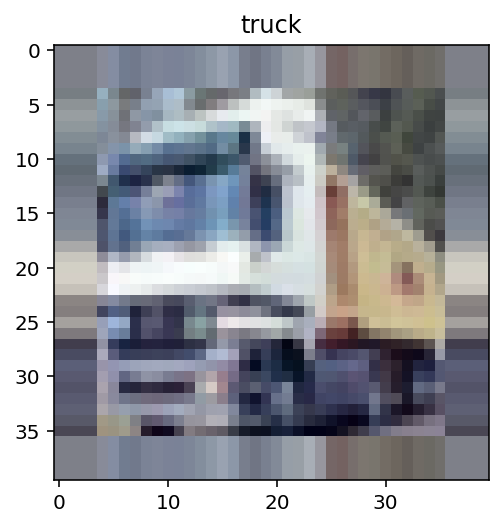

In [12]:
exampleId = 1
example = x_train[exampleId]
example = (example - np.min(example))/(np.max(example)-np.min(example))
plt.figure()
plt.title(classes[y_train[exampleId]])
example = np.rot90(example, k=0)
plt.imshow(example)
plt.show()

In [13]:
print(gc.collect())

model = DavidNet(weight=0.125)
batches_per_epoch = len_train//BATCH_SIZE + 1

# lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, EPOCHS], [0, LEARNING_RATE, 0])[0]

lr_schedule = lambda t: np.interp([t], [0.0001, (EPOCHS+1)//5, EPOCHS-3, EPOCHS-2,EPOCHS-1, EPOCHS], [0, LEARNING_RATE, 0.09,0.06,0.03,0.001])[0]



global_step = tf.train.get_or_create_global_step()
lr_func = lambda: lr_schedule(global_step/batches_per_epoch)/BATCH_SIZE
opt = tf.train.MomentumOptimizer(lr_func, momentum=MOMENTUM, use_nesterov=True)

if mixed_precision:
    opt = tf.train.experimental.enable_mixed_precision_graph_rewrite(opt)

data_aug1 = lambda x, y: (tf.image.random_flip_left_right(tf.random_crop(x, [32, 32, 3])), y)
# data_aug1 = lambda x,y: (x,y)
data_aug2 = lambda x,y: (tf.image.random_hue(tf.image.random_brightness(x,max_delta=0.1),max_delta=0.1),y)
# data_aug2 = lambda x,y: (x,y)
data_aug3 = lambda x, y: (tf.image.random_contrast(tf.image.random_saturation(x, 0.7, 1.3),0.7, 1.3), y)
# data_aug3 = lambda x,y: (x,y)
data_aug = lambda x, y:data_aug1(*data_aug2(*data_aug3(x,y)))

# rot90 = lambda x,y: (tf.image.rot90(x, np.random.choice([0,1,3],p=[1-rot90_proba,rot90_proba/2,rot90_proba/2])),y)

cutout_fn = get_cutout_eraser(p=1.0, pixel_level=True)

# rotate_one = lambda x : tf.keras.preprocessing.image.random_rotation(x, rg=45, row_axis=0,col_axis=1,channel_axis=2)



ssr = ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30,p=1.0)
rotate_one = lambda x: ssr(image=x)['image']

# 
rt = Rotate(limit=30,p=1.0)
rotate_one = lambda x: rt(image=x)['image']

rs = RandomScale(scale_limit=0.1, p=1.0)
scale_one = lambda x: rs(image=x)['image']

rshift = ShiftScaleRotate(shift_limit=0.05, scale_limit=0.0, rotate_limit=0,p=1.0)
shift_one = lambda x: rshift(image=x)['image']

gds = GridDistortion(num_steps=8, distort_limit=0.3,p=1.0)
gds_one = lambda x: gds(image=x)['image']

rcr = RandomCrop(40,40,p=1.0)
rcrop_one = lambda x: rcr(image=x)['image']

pad = PadIfNeeded(40,40)
pad_one = lambda x: pad(image=x)['image']

rot90_one = lambda x:np.rot90(x, k=np.random.choice([1,3]))

def constrained_augs(imgs,epoch):
    imgs = np.copy(imgs)
    fns = [cutout_fn,shift_one,scale_one,rotate_one,rot90_one,gds_one]
    probas = [cutout_proba,shift_proba,scale_proba,rotate_proba,rot90_proba,grid_proba]
    for i,im in enumerate(imgs):
        num_augs = np.random.choice(list(range(max_augs_per_image+1)),p=[no_aug_proba]+[(1-no_aug_proba)/max_augs_per_image]*max_augs_per_image)   
        choices = np.random.choice(list(range(6)),size=num_augs,replace=False,p=probas)   
        
        if 4 in choices:
            choices = [4]
        
#         print(choices)
        
        for j in choices:
            im = fns[j](im)
            if im.shape[0]<40:
                im = pad_one(im)
            if im.shape[0]>40:
                im = rcrop_one(im)
        imgs[i] = im
    
    return imgs


# 19 - 93.6
# 20 - 93.9

4


<Figure size 144x144 with 0 Axes>

Text(0.5, 1.0, 'truck')

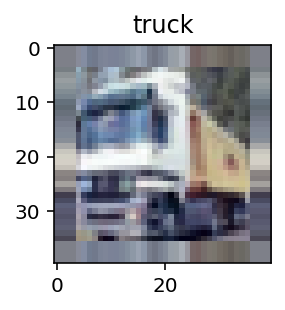

<Figure size 144x144 with 0 Axes>

Text(0.5, 1.0, 'truck')

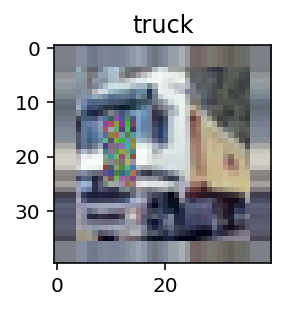


Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
1.9475566 -1.397924


<Figure size 144x144 with 0 Axes>

Text(0.5, 1.0, 'truck')

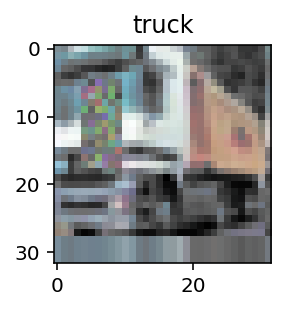

In [14]:
# exampleId = np.random.randint(0,len_train)
example = x_train[exampleId]


plt.figure(figsize=(2,2))
plt.title(classes[y_train[exampleId]])
ex = (example - np.min(example))/(np.max(example)-np.min(example))
plt.imshow(ex)
plt.show()


example = constrained_augs(np.array([example]),10)


plt.figure(figsize=(2,2))
plt.title(classes[y_train[exampleId]])
ex = example[0]
ex = (ex - np.min(ex))/(np.max(ex)-np.min(ex))
plt.imshow(ex)
plt.show()

ts = tf.data.Dataset.from_tensor_slices((example, np.array([y_train[exampleId]]))).map(data_aug, num_parallel_calls=tf.data.experimental.AUTOTUNE).prefetch(1)
x,y = next(ts.make_one_shot_iterator())
x,y = x.numpy(),y.numpy()
example=x
print(np.max(example),np.min(example))
ex = (example - np.min(example))/(np.max(example)-np.min(example))
plt.figure(figsize=(2,2))
plt.title(classes[y_train[exampleId]])
plt.imshow(ex)
plt.show()

In [15]:
print(gc.collect())
t1 = time.time()
train_data = {}
for epoch in range(EPOCHS):
    
    if epoch%2==1:
        print("Epoch = ",epoch," Time = ",(time.time()-t1))
    xt = constrained_augs(x_train, epoch)
    train_set = tf.data.Dataset.from_tensor_slices((xt, y_train)).map(data_aug, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(len_train).batch(len_train).prefetch(len_train)
    i = 0
    for x,y in train_set:
        assert x.numpy().shape[0]==len_train
        train_set = (x.numpy(),y.numpy())
        i = i+1
    assert i==1
    train_data[epoch] = train_set
t2 = time.time()
"%.1f" %(t2-t1)


4082
Epoch =  1  Time =  14.096076250076294
Epoch =  3  Time =  42.32674956321716
Epoch =  5  Time =  70.65695714950562
Epoch =  7  Time =  98.83464741706848
Epoch =  9  Time =  126.70173645019531
Epoch =  11  Time =  155.18763971328735
Epoch =  13  Time =  183.5972969532013
Epoch =  15  Time =  211.9202103614807
Epoch =  17  Time =  240.15589427947998
Epoch =  19  Time =  268.4171497821808
Epoch =  21  Time =  296.8147909641266
Epoch =  23  Time =  324.7967252731323


'339.7'

0
epoch = 1 lr: 0.0800 | train loss: 1.7256 train acc: 0.374 val loss: 1.2881 val acc: 0.538 epoch time: 25.38 time: 25.38
epoch = 2 lr: 0.1600 | train loss: 1.0931 train acc: 0.611 val loss: 1.0987 val acc: 0.645 epoch time: 17.68 time: 43.07
epoch = 3 lr: 0.2400 | train loss: 0.8852 train acc: 0.690 val loss: 1.1662 val acc: 0.646 epoch time: 17.57 time: 60.64
epoch = 4 lr: 0.3200 | train loss: 0.7985 train acc: 0.726 val loss: 0.6918 val acc: 0.763 epoch time: 17.48 time: 78.12
epoch = 5 lr: 0.4000 | train loss: 0.7220 train acc: 0.749 val loss: 0.7971 val acc: 0.738 epoch time: 17.51 time: 95.63
epoch = 6 lr: 0.3806 | train loss: 0.6320 train acc: 0.782 val loss: 0.7321 val acc: 0.769 epoch time: 17.51 time: 113.14
epoch = 7 lr: 0.3613 | train loss: 0.5555 train acc: 0.808 val loss: 0.5270 val acc: 0.828 epoch time: 17.62 time: 130.76
epoch = 8 lr: 0.3419 | train loss: 0.4991 train acc: 0.825 val loss: 0.5158 val acc: 0.828 epoch time: 17.59 time: 148.35
epoch = 9 lr: 0.3225 | trai

<Figure size 432x288 with 0 Axes>

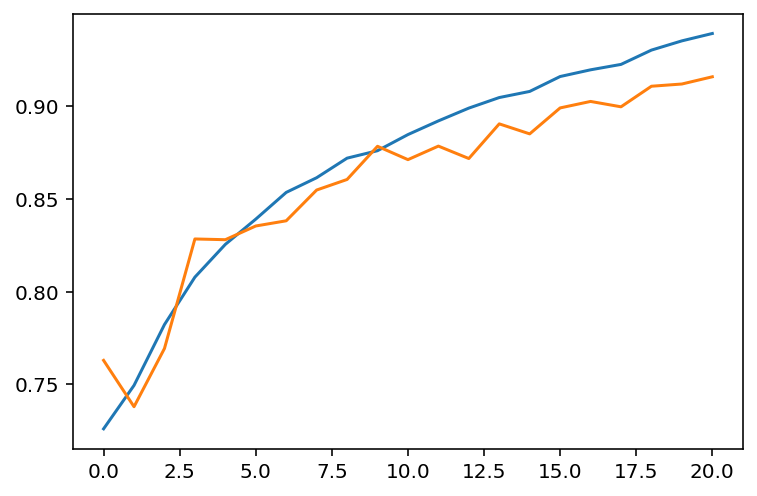

In [16]:
print(gc.collect())
t = time.time()
t_last = time.time()
train_accs = []
test_accs = []
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE).prefetch(1)

for epoch in range(EPOCHS):
    train_loss = test_loss = train_acc = test_acc = 0.0
    train_set = train_data[epoch]
    train_set = tf.data.Dataset.from_tensor_slices(train_set).batch(BATCH_SIZE).prefetch(1)
    tf.keras.backend.set_learning_phase(1)
    for (x, y) in train_set:
        with tf.GradientTape() as tape:
            loss, correct = model(x, y)

        var = model.trainable_variables
        grads = tape.gradient(loss, var)
        for g, v in zip(grads, var):
            g += v * (WEIGHT_DECAY/(epoch+1)) * BATCH_SIZE
        opt.apply_gradients(zip(grads, var), global_step=global_step)

        train_loss += loss.numpy()
        train_acc += correct.numpy()

    tf.keras.backend.set_learning_phase(0)
    for (x, y) in test_set:
        loss, correct = model(x, y)
        test_loss += loss.numpy()
        test_acc += correct.numpy()

    t2 = time.time()
    epoch_time = t2 - t_last
    t_last = t2
    train_accs.append(train_acc / len_train)
    test_accs.append(test_acc / len_test)
    print("epoch = %s"%(epoch+1),'lr: %.4f' % (lr_schedule(epoch+1)), '| train loss: %.4f' %(train_loss / len_train), 'train acc: %.3f' % (train_acc / len_train), 'val loss: %.4f' % (test_loss / len_test), 'val acc: %.3f' %(test_acc / len_test),"epoch time: %.2f"%(epoch_time), 'time: %.2f'%(t2 - t))
    
    
plt.figure()
plt.plot(train_accs[3:])
plt.plot(test_accs[3:])
plt.show()

# 
    
# 0.936

# epoch = 3 lr: 0.2400 | train loss: 0.6618 train acc: 0.769 val loss: 0.8386 val acc: 0.720

In [17]:
print("epoch = %s"%(epoch+1),'lr: %.4f' % (lr_schedule(epoch+1)), '| train loss: %.4f' %(train_loss / len_train), 'train acc: %.3f' % (train_acc / len_train), 'val loss: %.4f' % (test_loss / len_test), 'val acc: %.3f' %(test_acc / len_test),"epoch time: %.2f"%(epoch_time), 'time: %.2f'%(t2 - t))


epoch = 24 lr: 0.0010 | train loss: 0.1834 train acc: 0.939 val loss: 0.2701 val acc: 0.916 epoch time: 17.43 time: 429.21


In [0]:
# each image should have only 2-3 augments
# when using augmentations use a larger batch size
# when using augmentations use both augmented and non augmented image in same batch.
# or use a milder augmentation strategy.